In [ ]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

from tqdm.auto import tqdm

# Data

<class 'numpy.ndarray'>
(256, 2)


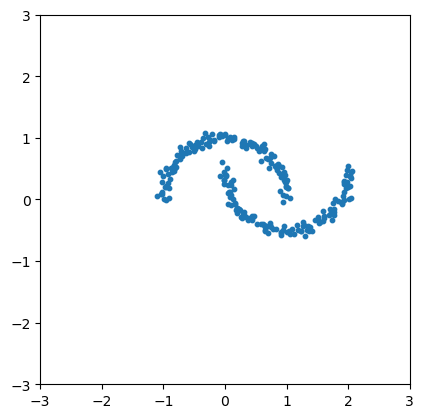

In [ ]:
X, _ = make_moons(256, noise=0.05)
print(type(X))
print(X.shape)
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Flow Matching

In [ ]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        """ 
        t     : (batch_size, 1)
        x_t   : (batch_size, dim)

        input : (batch_size, dim + 1)
        output: (batch_size, dim)
        """
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        """ 
        x_t     : (sample_size, dim)
        t_start : ()
        t_end   : ()
        """
        # (sample_size, 1)
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(t=t_start, x_t=x_t) * (t_end - t_start) / 2)

$$
\frac{dx}{dt} = f(t, x)
$$

The midpoint method for solving the above ODE:

$$
x(t + \Delta t) \approx x(t) + \Delta t \cdot f \left( t + \frac{\Delta t}{2}, x(t) + \frac{\Delta t}{2} f(t, x) \right)
$$

# Training

$$
\mathcal{L}^{\text{{OT,Gauss}}}_{\text{CFM}}(\theta) = \mathbb{E}_{t, X_0, X_1} \| u^{\theta}_{t}(X_t) -(X_1-X_0) \|^2 
$$

$$
t \sim U[0,1],\, X_0 \sim \mathcal{N}(0,I),\, X_1 \sim q
$$

$$
X_t = (1-t)X_0 + tX_1
$$

In [ ]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

bs = 256  # batch size

losses = []

for _ in tqdm(range(10000)):
    x_1 = Tensor(make_moons(bs, noise=0.05)[0])   # (bs, 2)
    x_0 = torch.randn_like(x_1)                   # (bs, 2)
    t = torch.rand(len(x_1), 1)                   # (bs, 1)  
    
    x_t = (1 - t) * x_0 + t * x_1                 # (bs, 2)
    dx_t = x_1 - x_0                              # (bs, 2)
    
    loss = loss_fn(flow(t=t, x_t=x_t), dx_t)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

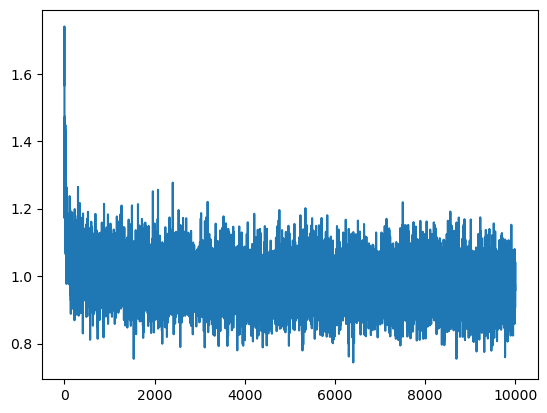

In [ ]:
plt.plot(losses);

# Sampling

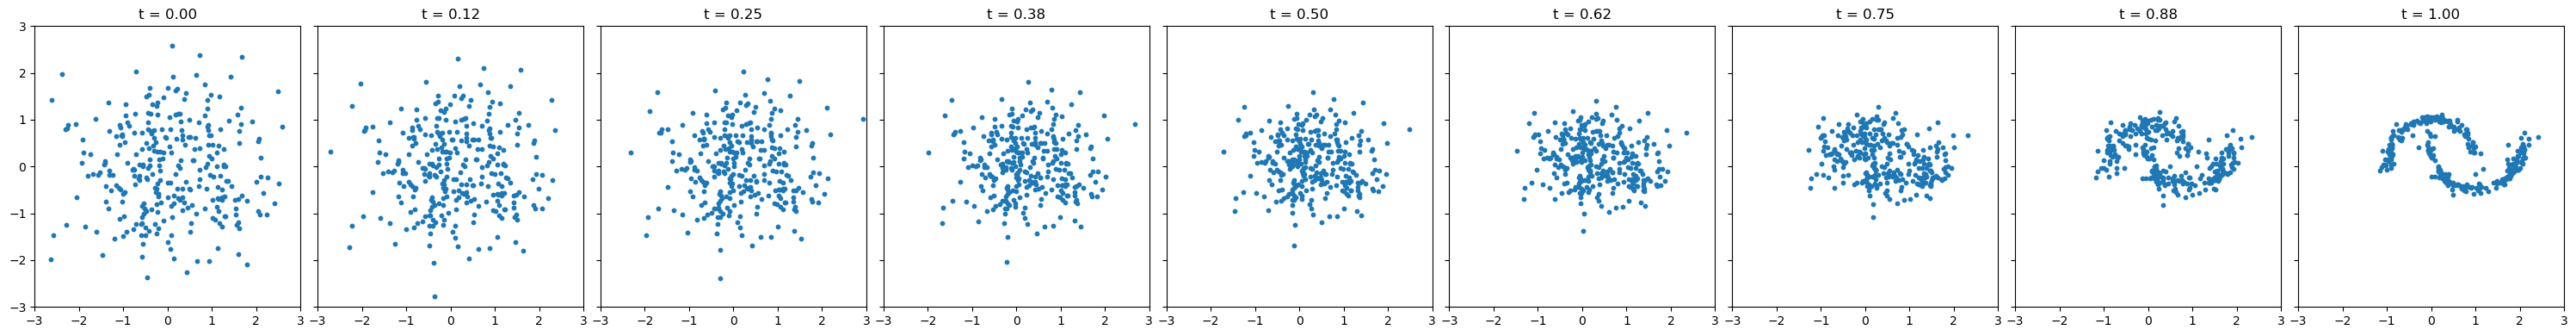

In [ ]:
x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)  # [0dt, 1dt, 2dt, ..., ndt]; ndt = 1.0

# t = 0
axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    """ 
    t=0       -> t=dt
    t=dt      -> t=2dt
    t=2dt     -> t=3dt
    ...
    t=(n-1)dt -> t=ndt
    """
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()